## `QuackBLB` : Bag of Little Bootstraps for Big Data powered by `DuckDB`

[reference](https://arxiv.org/abs/1112.5016)

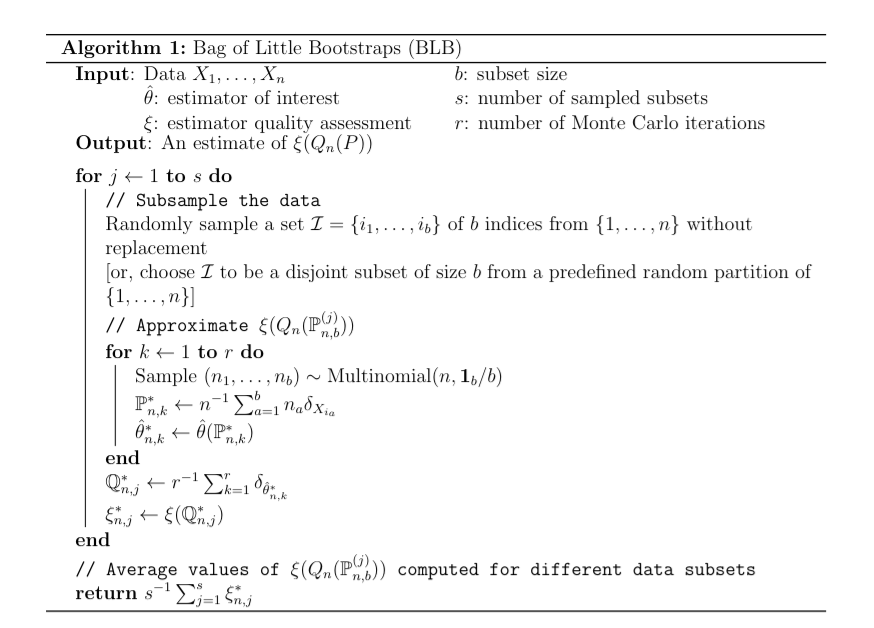

we perform subsampling in duckDB

In [1]:
import numpy as np
import duckdb
from sklearn.linear_model import LinearRegression

In [2]:
from blb.QuackBLB import QuackBLB

In [3]:
# Setup DuckDB with example data
N = 1_000_000
conn = duckdb.connect("dummy_dataset.db")
conn.execute("DROP TABLE IF EXISTS base")
conn.execute("DROP TABLE IF EXISTS example")
# Create example table
conn.execute(
    f"""
    CREATE TABLE example AS
    WITH base AS (
        SELECT
            random() as x1,
            random() as x2
        FROM range({N})
    )
    SELECT
        x1,
        x2,
        2 * x1 + 1 * x2 + 2 * random() as y
    FROM base
"""
)

In [4]:
# Define estimator for regression coefficients
def coef_estimator(data):
    X = data[:, :-1]  # assuming last column is y
    y = data[:, -1]
    return LinearRegression().fit(X, y).coef_

In [5]:
# Get total count for n
print(n := conn.execute("SELECT COUNT(*) FROM example").fetchone()[0])

1000000


### QuackBLB class

In [6]:
blb = QuackBLB(estimator=coef_estimator)
query = "SELECT * from example"

#### point estimate

in reality, probably don't estimate this over the whole dataset.

In [7]:
print(pt_est := coef_estimator(conn.execute(query).fetchdf().values))

[2.00049898 1.00004307]


#### Bag of Little Bootstraps confidence interval

In [8]:
%%time
ci_lower, ci_upper = blb.confidence_interval(conn, query, n)

CPU times: user 2min 21s, sys: 16.1 s, total: 2min 37s
Wall time: 2min 37s


In [9]:
np.c_[ci_lower, pt_est, ci_upper]

array([[1.99481707, 2.00049898, 2.00251157],
       [0.99755245, 1.00004307, 1.00499192]])